In [1]:
import pandas as pd
df = pd.read_csv('c:/data/ozone/ozone2.csv')
df.head()

,Ozone,Result,Solar.R,Wind,Temp,Month,Day
0,41.00000,0,190.000000,7.4,67,5,1
1,36.00000,0,118.000000,8.0,72,5,2
2,12.00000,0,149.000000,12.6,74,5,3
3,18.00000,0,313.000000,11.5,62,5,4
4,42.12931,1,185.931507,14.3,56,5,5


c:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '분류\n (0: 부족, 1: 정상)')

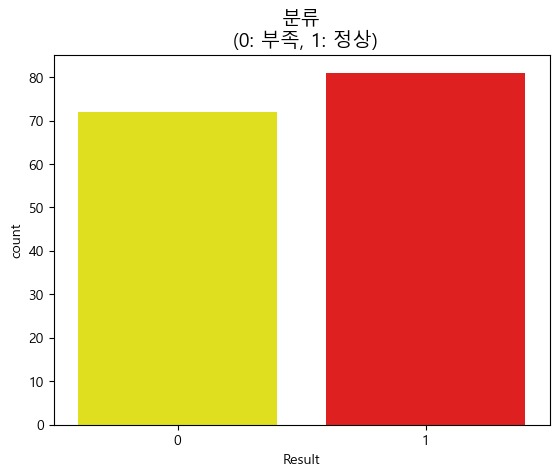

In [2]:
#데이터 불균형 확인
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import seaborn as sns

colors = ["yellow", "red"]
sns.countplot('Result', data=df, palette=colors)
plt.title('분류\n (0: 부족, 1: 정상)', fontsize=14)

In [3]:
train_cols = df.columns[2:-2]
X = df[train_cols]
y = df['Result']

In [4]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample, columns=train_cols)
y_samp = pd.DataFrame(data=y_sample, columns=['Result'])
df_samp = pd.concat([X_samp, y_samp], axis=1)
df_samp['Result'].value_counts()

0    72
1    72
Name: Result, dtype: int64

In [5]:
X = X_samp
y = y_samp

c:\anaconda\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


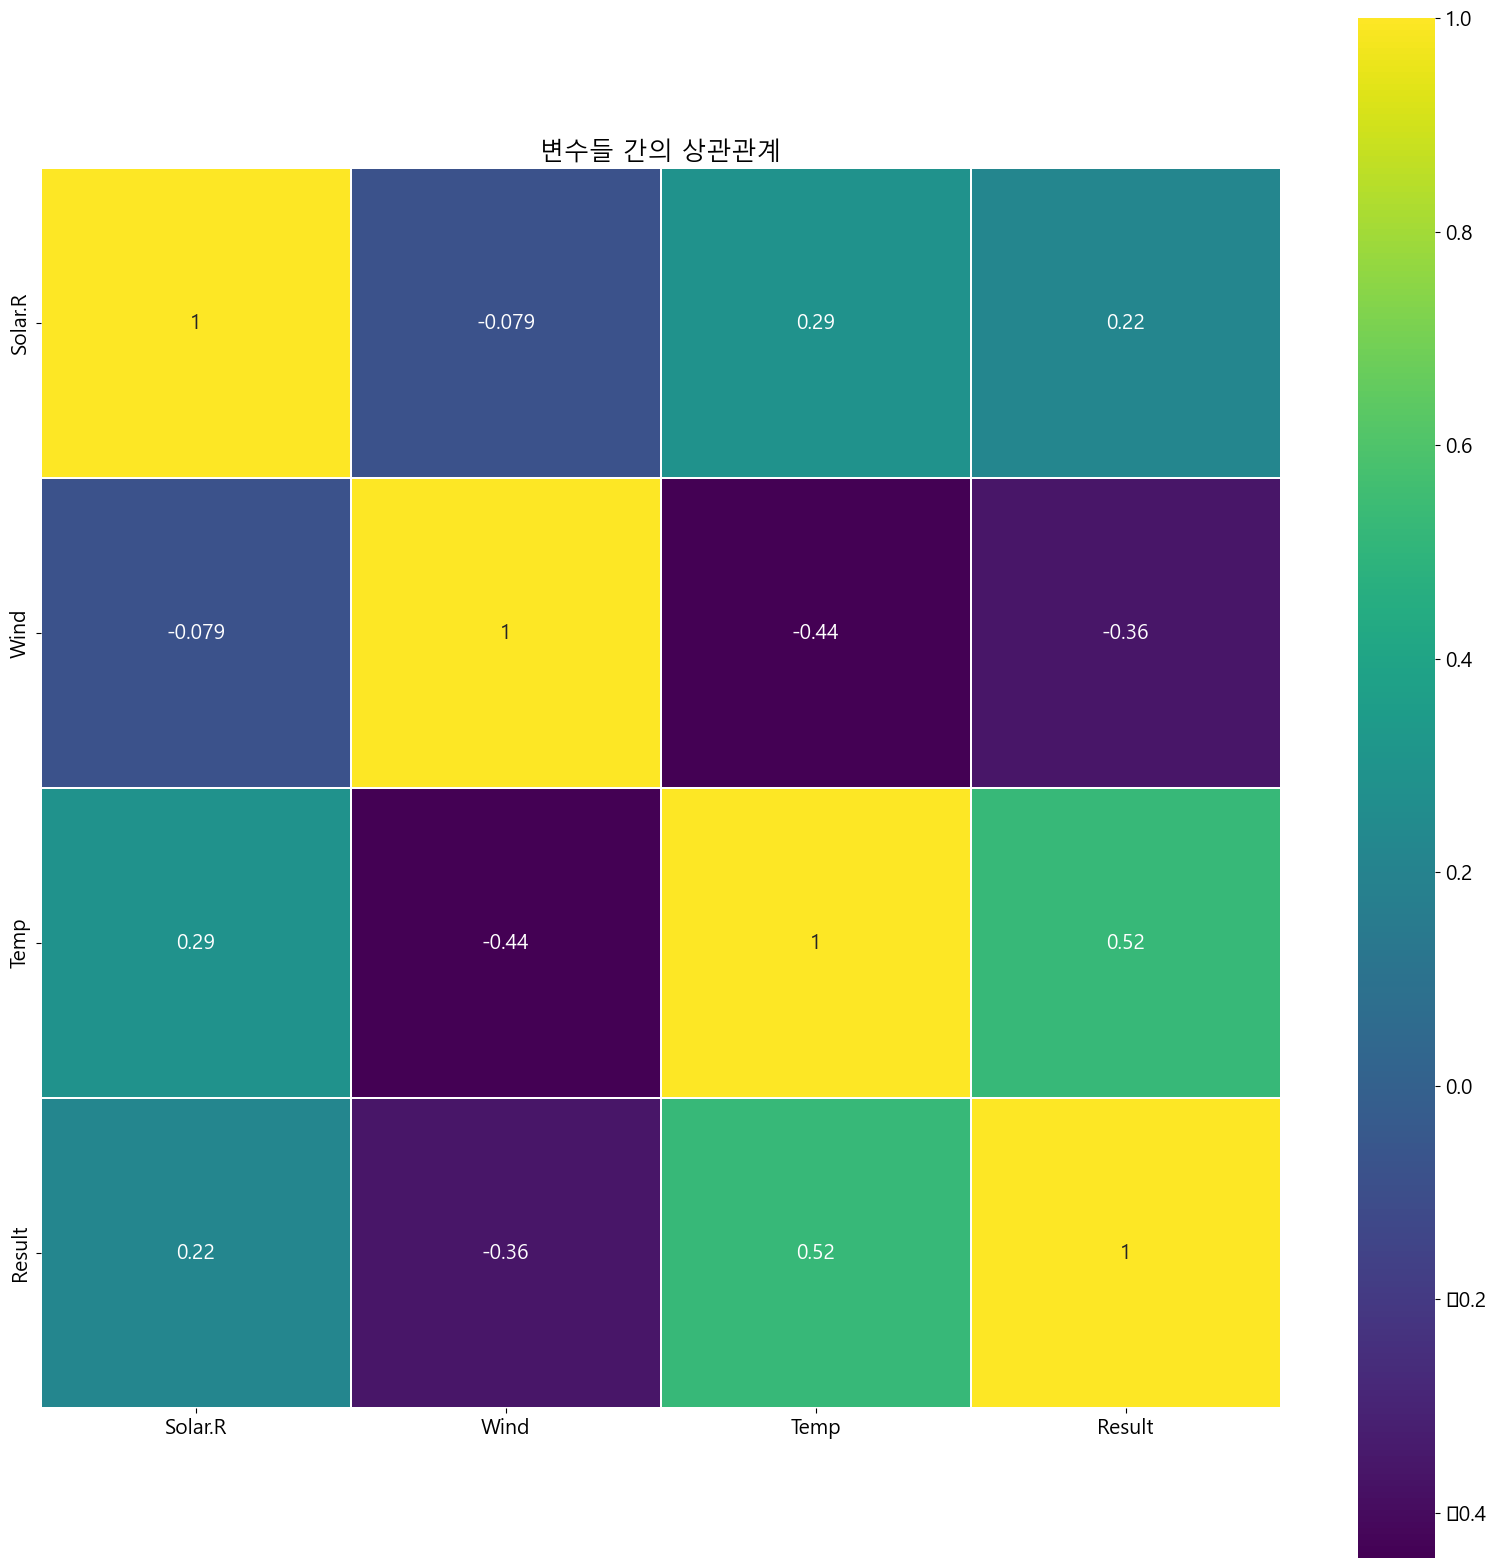

In [6]:
#상관계수 행렬 그래프
plt.figure(figsize=(20,20))
plt.rc('font', size=15)
sns.heatmap(df_samp.corr(), linewidths=0.01, square=True, annot=True,
            cmap=plt.cm.viridis, linecolor='white')
plt.title('변수들 간의 상관관계')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=7)

In [8]:
#모델 구성
from keras.models import Sequential
from keras.layers import Dense
model = Sequential(name='model1')
model.add(Dense(128, input_shape=(len(X_train.columns), ), activation='relu',
                name='hidden-1'))
model.add(Dense(64, activation='relu', name='hidden-2'))
model.add(Dense(32, activation='relu', name='hidden-3'))
model.add(Dense(1, activation='sigmoid', name='output'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [9]:
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-1 (Dense)            (None, 128)               512       
                                                                 
 hidden-2 (Dense)            (None, 64)                8256      
                                                                 
 hidden-3 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


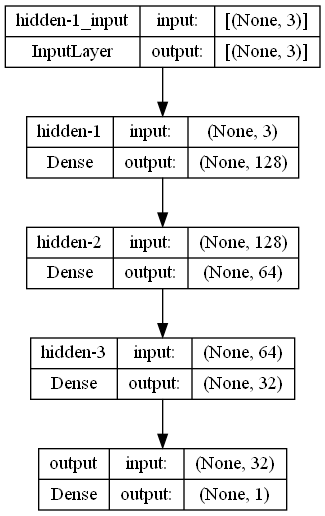

In [10]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
#텐서보드 경로
from datetime import datetime
import tensorflow as tf 
logdir="c:/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
logdir
# # anaconda prompt에서 tensorboard --logdir=경로 후 뜨는 서버주소로 접속

'c:/logs/20230414-161722'

In [13]:
#모델학습
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(X_train_scaled, y_train, epochs=600, 
                 callbacks=[tensorboard_callback])

Epoch 1/600
4/4 [==============================] - 1s 6ms/step - loss: 0.2535 - accuracy: 0.4522
Epoch 2/600
4/4 [==============================] - 0s 4ms/step - loss: 0.2321 - accuracy: 0.6348
Epoch 3/600
4/4 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.7652
Epoch 4/600
4/4 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.7913
Epoch 5/600
4/4 [==============================] - 0s 4ms/step - loss: 0.1922 - accuracy: 0.7652
Epoch 6/600
4/4 [==============================] - 0s 4ms/step - loss: 0.1824 - accuracy: 0.7739
Epoch 7/600
4/4 [==============================] - 0s 4ms/step - loss: 0.1736 - accuracy: 0.7826
Epoch 8/600
4/4 [==============================] - 0s 4ms/step - loss: 0.1675 - accuracy: 0.7826
Epoch 9/600
4/4 [==============================] - 0s 4ms/step - loss: 0.1616 - accuracy: 0.7739
Epoch 10/600
4/4 [==============================] - 0s 4ms/step - loss: 0.1573 - accuracy: 0.7826
Epoch 11/600
4/4 [===========

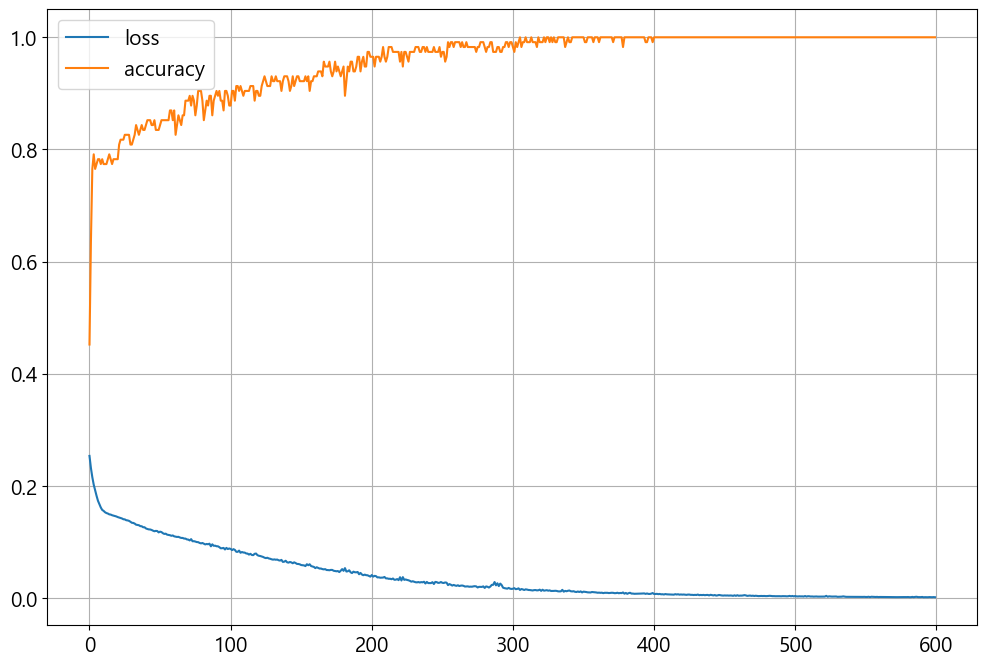

In [14]:
#모델 학습 과정 시각화
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.grid()
plt.show()

In [15]:
#학습용 모델 평가
scores = model.evaluate(X_train_scaled, y_train)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

4/4 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000
[0.0016200738027691841, 1.0]
accuracy: 100.00%


In [16]:
#검증용 모델 평가
scores = model.evaluate(X_test_scaled, y_test)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

1/1 [==============================] - 0s 22ms/step - loss: 0.2036 - accuracy: 0.7931
[0.20358403027057648, 0.7931034564971924]
accuracy: 79.31%


In [17]:
#새로운 값 예측
# 일조량 25, 풍량 10.8, 화씨온도 71도일 때의 오존량
test_set = [[25, 10.8, 71]]
test_set=scaler.transform(test_set)
print(model.predict(test_set))

1/1 [==============================] - 0s 78ms/step
[[0.30172572]]


c:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
# 일조량 255, 풍량 4.3, 화씨온도 90도일 때의 오존량
test_set = [[25, 4.3, 90]]
test_set=scaler.transform(test_set)
print(model.predict(test_set))

c:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
[[0.9999995]]


In [19]:
#모델 저장
import joblib
model.save('c:/data/ozone/model.h5')
joblib.dump(scaler, 'c:/data/ozone/scaler.model')

['c:/data/ozone/scaler.model']